In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from bundlenet_continuous_variant import BunDLeNet, train_model
from functions import preprocess_data, prep_data, plotting_neuronal_behavioural, plot_latent_timeseries, timeseries_train_test_split
from plotting_functions import plot_phase_space

import os
os.chdir('../..')

%reload_ext autoreload
%autoreload 2
os.getcwd()

2024-03-06 13:51:31.197669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 13:51:31.197689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 13:51:31.198596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 13:51:31.203602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 13:51:31.773356: W tensorflow/compiler/tf2

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data

In [2]:
fish_data_id = '220127_F4_F4_run2' #220119_F2_F2_run11, 220127_F4_F4_run2
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_vigour.npy'

In [3]:
X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

## BunDLe-Net

In [4]:
models = []
history = []

for i in range(10):
    
    algorithm = 'BunDLeNet'
    X_, B_ = prep_data(X, B, win=2)

    ### Deploy BunDLe Net
    model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
    model.build(input_shape=X_.shape)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

    X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
    train_history, test_history = train_model(
        X_train,
        B_train_1,
        model,
        optimizer,
        gamma=0.9, 
        n_epochs=200,
        pca_init=False,
        best_of_5_init=False,
        validation_data = (X_test, B_test_1)
    )
    
    models.append(model)
    history.append([train_history, test_history])

2024-03-06 13:51:33.150396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 13:51:33.208980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 13:51:33.209161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

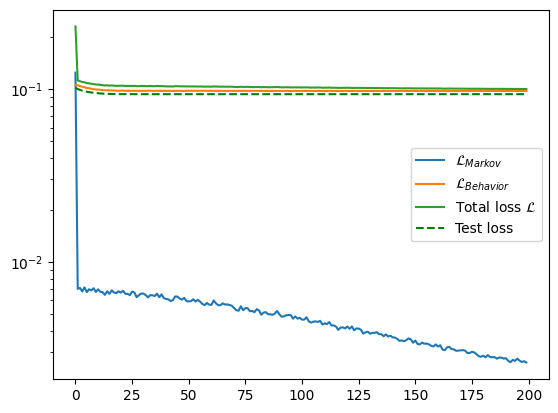

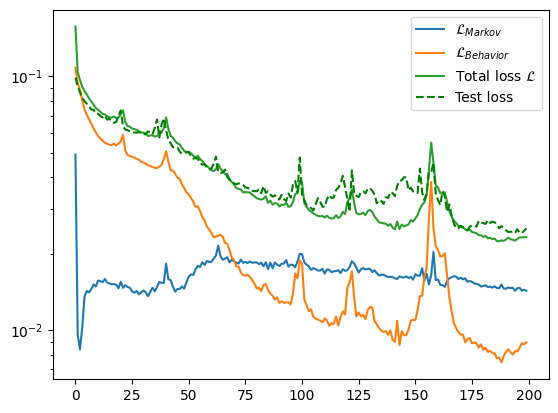

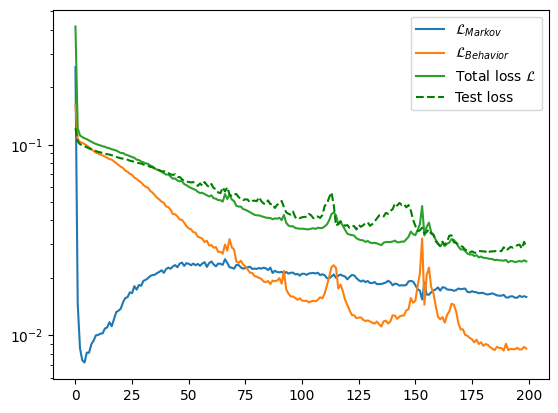

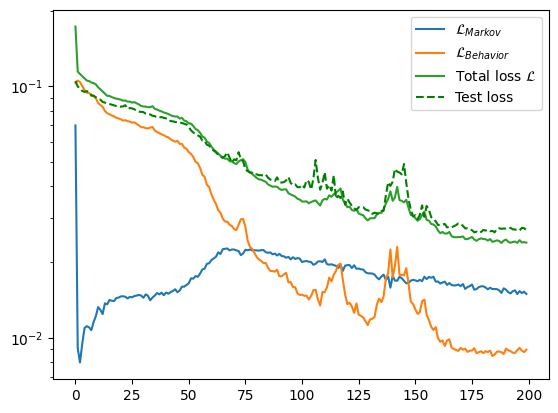

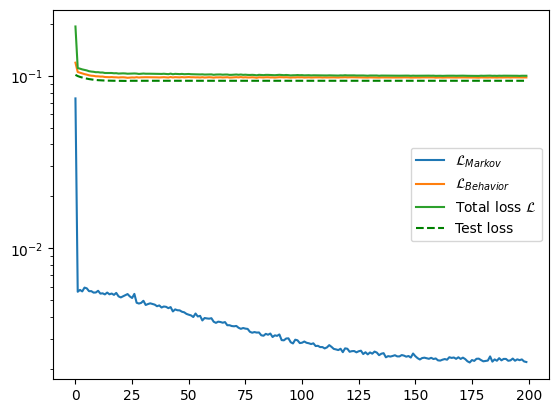

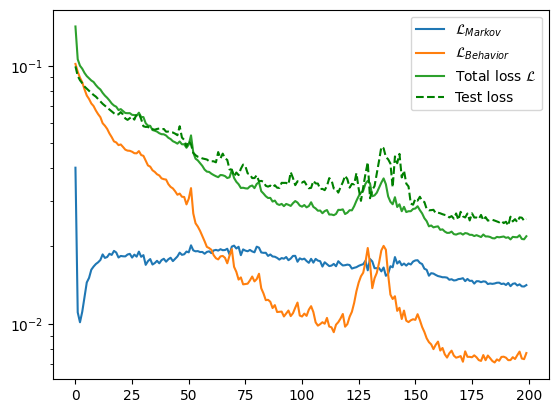

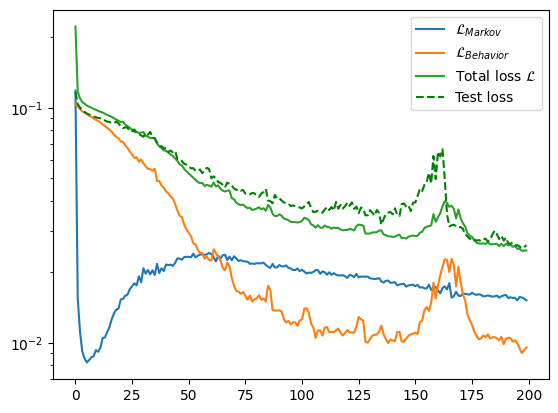

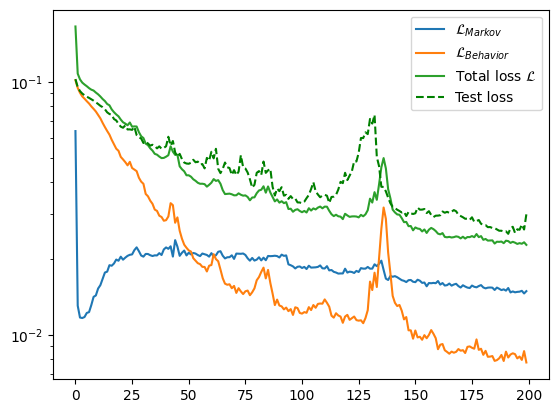

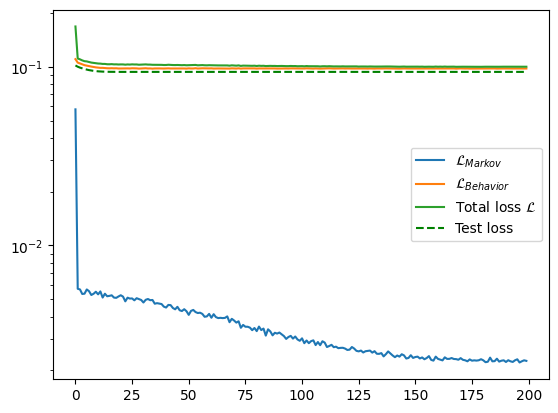

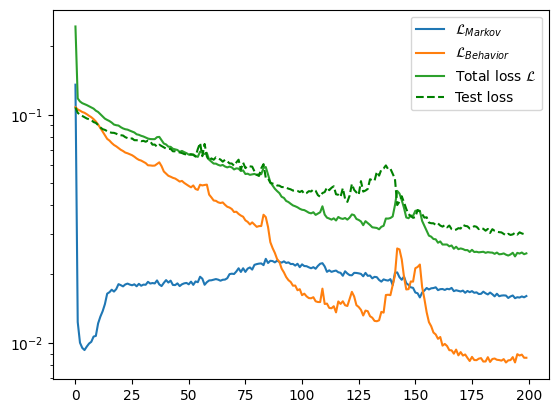

In [5]:
%matplotlib inline
for i, _ in enumerate(history):
    train_history = history[i][0] 
    test_history = history[i][1]
    # Training losses vs epochs
    plt.figure()
    for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
        plt.semilogy(train_history[:,i], label=label)

    plt.semilogy(test_history[:,-1], label="Test loss", linestyle="--", color='g')       
    plt.legend()
plt.show()


In [6]:
history = np.array(history)
train_loss = history[:,0,-1,-1]
test_loss = history[:,1,-1,-1]

model = models[np.argmin(test_loss)]

idx_optimal = np.argmin(test_loss)
model_opt = models[idx_optimal]
train_loss_opt = train_loss[idx_optimal]
test_loss_opt = test_loss[idx_optimal]
test_loss_opt

0.025170653872191907

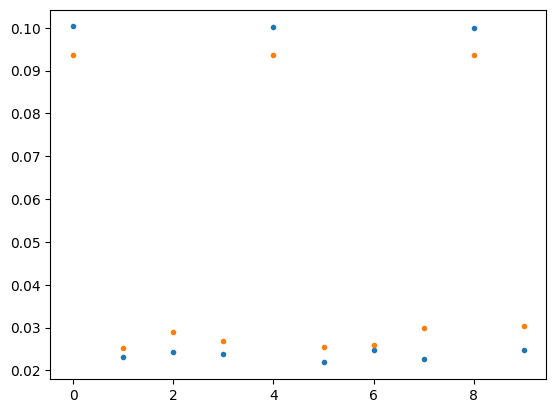

In [7]:
plt.figure()
plt.plot(train_loss, '.')
plt.plot(test_loss, '.')

## Projecting into latent space

In [8]:
### Projecting into latent space
Y0_ = model.tau(X_[:,0]).numpy()
Y0_.shape

(3174, 3)

In [9]:
algorithm = 'BunDLeNet_pure_behaviour'
os.makedirs('data/generated/saved_Y/fish', exist_ok=True)
np.savetxt('data/generated/saved_Y/fish/Y0__' + algorithm + '_fish_' + fish_data_id, Y0_)
np.savetxt('data/generated/saved_Y/fish/B__' + algorithm + '_fish_' + fish_data_id, B_)

In [10]:
algorithm = 'BunDLeNet'
Y0_ = np.loadtxt('data/generated/saved_Y/fish/Y0__' + algorithm + '_fish_' + fish_data_id)
B_ = np.loadtxt('data/generated/saved_Y/fish/B__' + algorithm + '_fish_' + fish_data_id)

## Visualising embedding

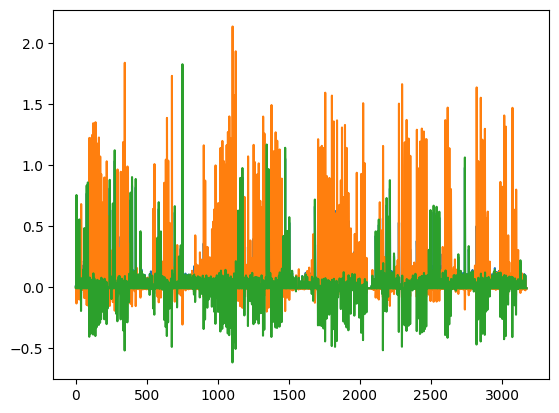

In [11]:
%matplotlib inline
plt.figure()
plt.plot(Y0_)

<IPython.core.display.Javascript object>


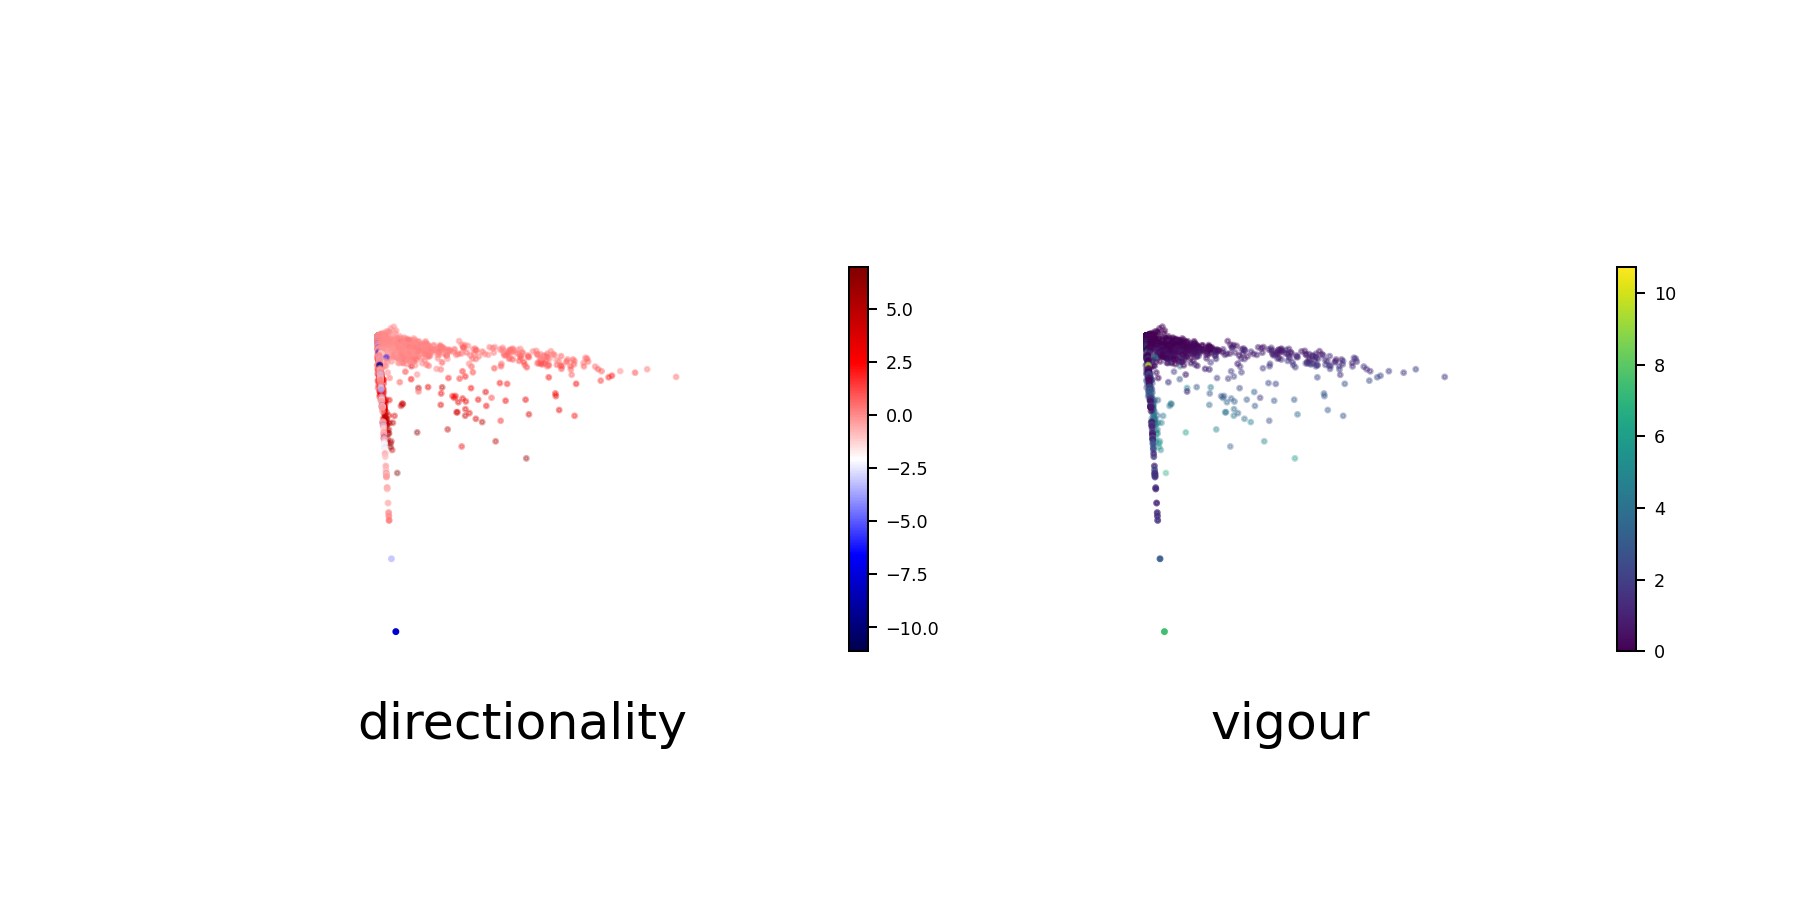

In [12]:
%matplotlib notebook
def plot_embedding(Y0_, B_, title=None, **kwargs):
    elev, azim, roll = 27,10,0
    fig = plt.figure(figsize=(10, 5))
    plt.suptitle(title,
                 fontsize=20)
    ax = plt.subplot(121, projection = '3d')
    ax.view_init(**kwargs)
    ax.set_title('directionality', fontsize=20, y=0)
    x = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 0],
                   cmap='seismic',
                   s=3
    )
    ax.axis('off')
    xc = plt.colorbar(x, fraction=0.03, pad=0.05)
    xc.ax.tick_params(labelsize=7)

    ax = plt.subplot(122, projection = '3d')
    ax.view_init(**kwargs)
    y = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 1],
                   cmap='viridis',
                   s=3
    )
    ax.axis('off')
    ax.set_title('vigour', fontsize=20, y=0)
    yc = plt.colorbar(y, fraction=0.03, pad=0.05)
    yc.ax.tick_params(labelsize=7)
    plt.show()

plot_embedding(Y0_, B_, elev=80, azim=-12 )

<IPython.core.display.Javascript object>


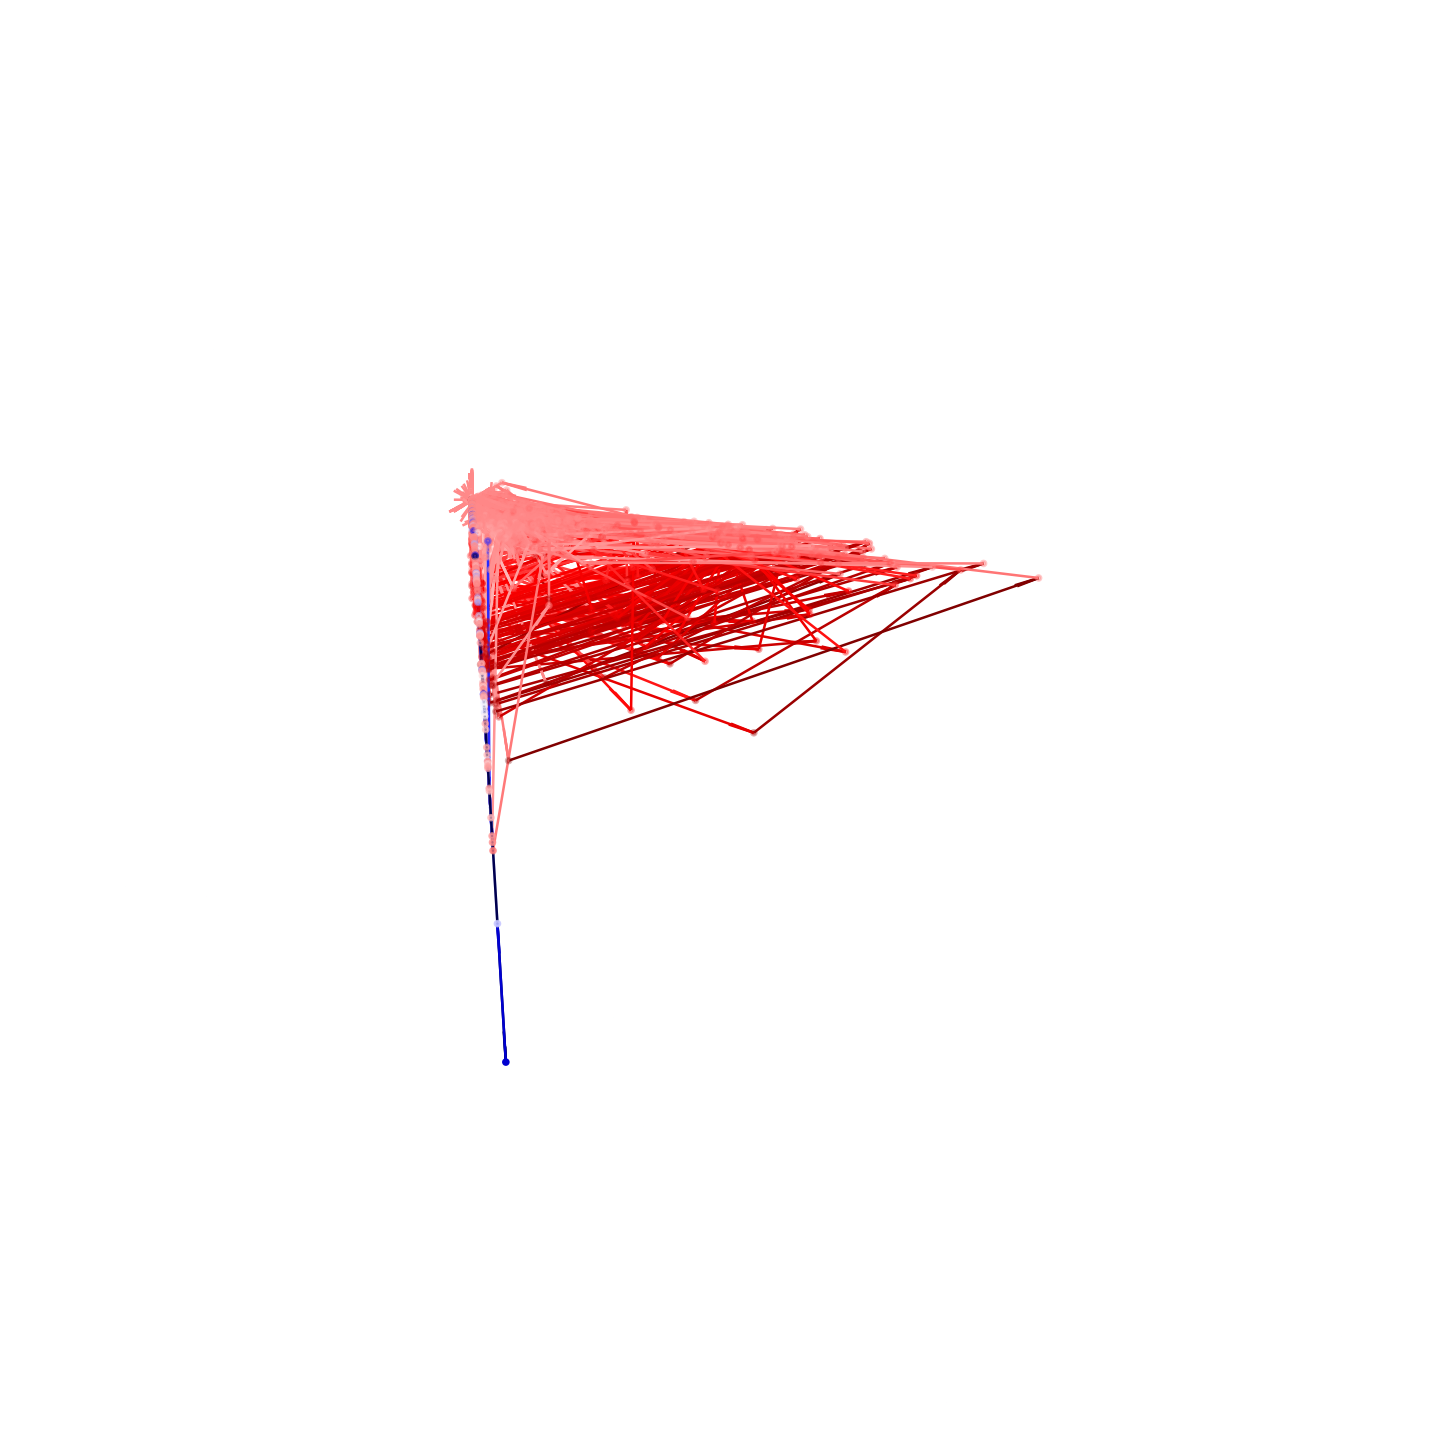

/tmp/ipykernel_102778/3146946992.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)
/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:2606: RuntimeWarning: invalid value encountered in multiply
  arrow_dt = shaft_dt * arrow_length_ratio


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [13]:
def plot_ps_(fig, ax, Y, B, cmap='viridis'):
    
    def color_transform(a, cmap=cmap):
        normalized_value = (a - B.min()) / (B.max() - B.min())
        cmap = plt.get_cmap(cmap)
        rgba_color = cmap(normalized_value)
        rgb_color = rgba_color[:3]

        return rgb_color
    
    for i in range(len(Y) - 1):
        d = (Y[i+1] - Y[i])
        ax.quiver(Y[i, 0], Y[i, 1], Y[i, 2],
                  d[0], d[1], d[2],
                  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)
    ax.set_axis_off()  

    x = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2],
                   c=B,
                   cmap=cmap,
                   s=4)
    return fig, ax

def plot_phase_space(Y, B, cmap='viridis', **kwargs):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.view_init(**kwargs)
    plot_ps_(fig, ax, Y, B, cmap)
    plt.show()
    return fig, ax

def rotating_plot(Y, B, cmap, filename='rotation.gif'):
    import matplotlib.animation as animation
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    def rotate(angle):
        ax.view_init(azim=angle)

    fig, ax = plot_ps_(fig, ax, Y=Y, B=B, cmap=cmap)
    rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 5), interval=150)
    rot_animation.save(filename, dpi=150, writer='imagemagick')
    plt.show()
    return ax

plot_phase_space(Y0_, B_[:,0],  elev=80, azim=-12, cmap='seismic')

<IPython.core.display.Javascript object>


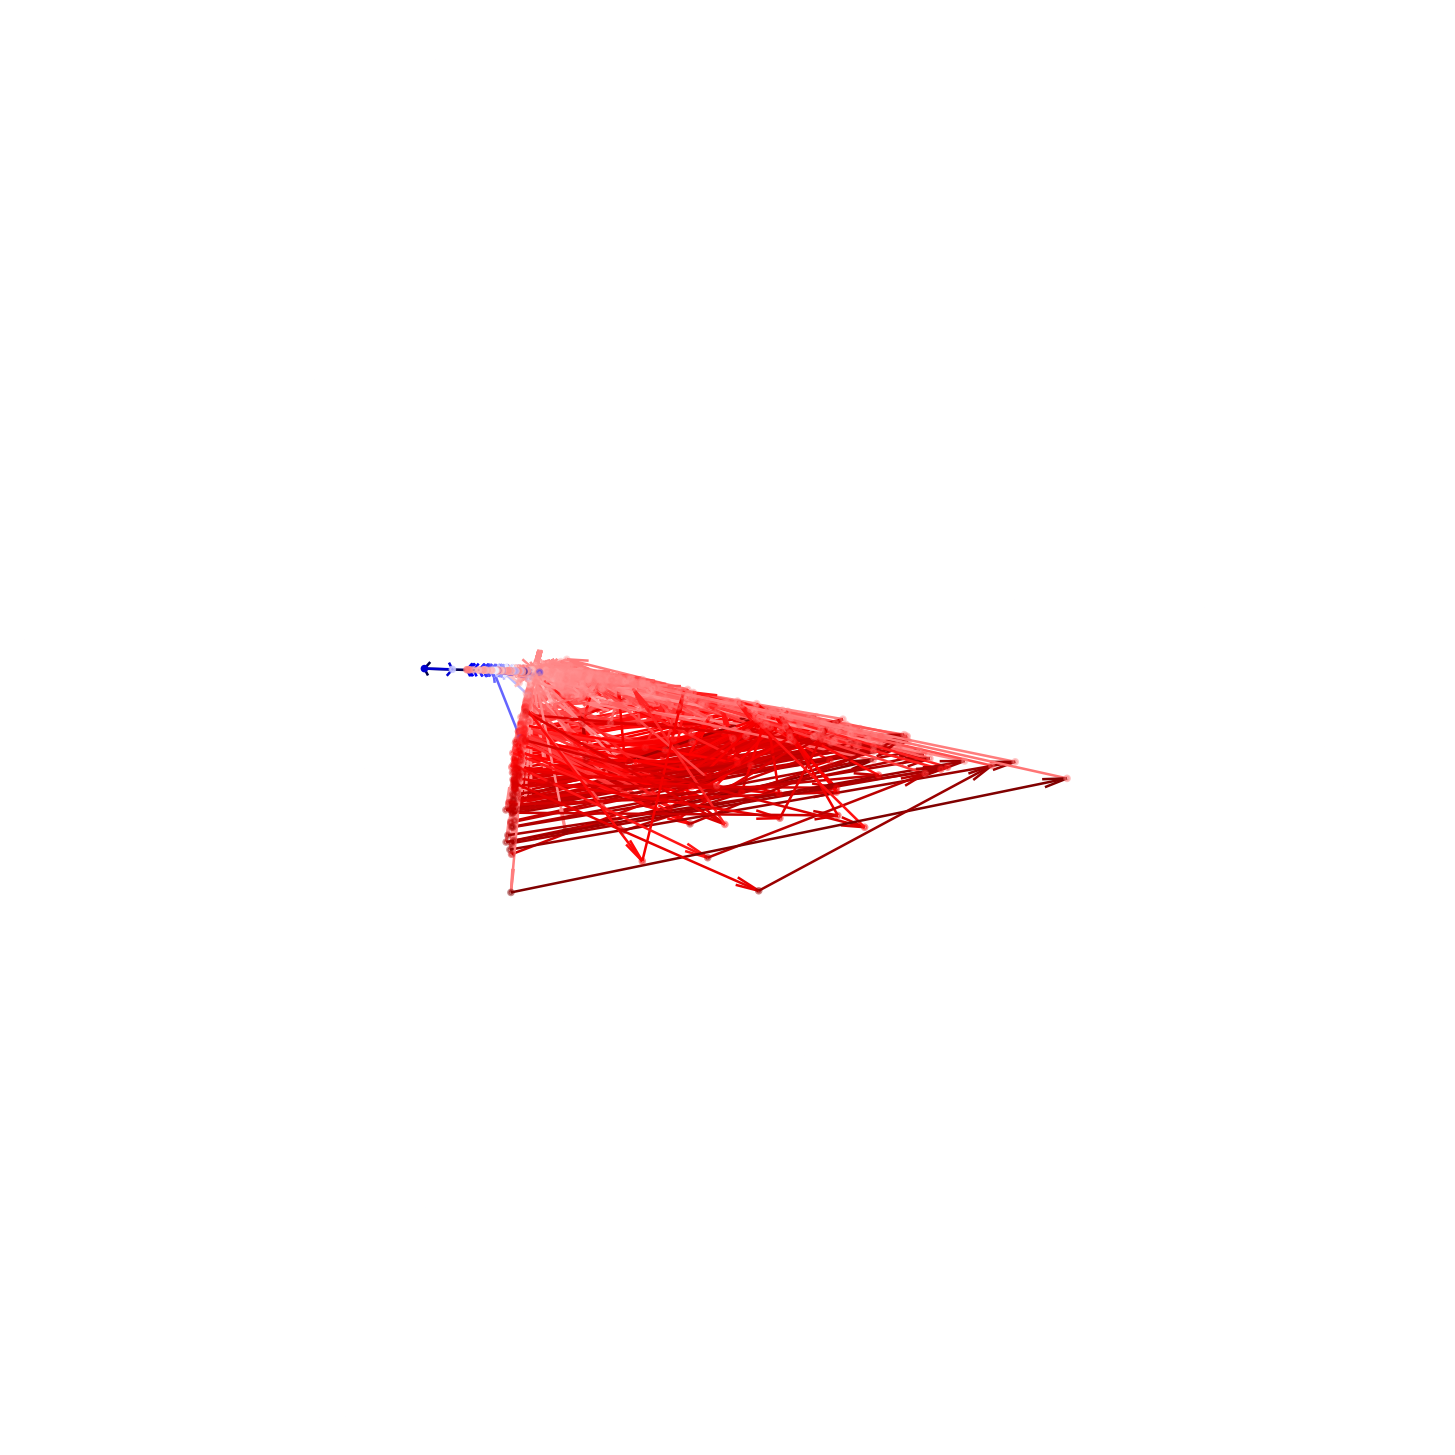

/tmp/ipykernel_102778/3146946992.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)


<Axes3D: >

In [14]:
rotating_plot(
    Y0_, 
    B_[:,0], 
    cmap='seismic', 
    filename='experimental/bundle_net_on_fish/rotation_'+ algorithm + '_fish_' + fish_data_id +'.gif'
)

<IPython.core.display.Javascript object>


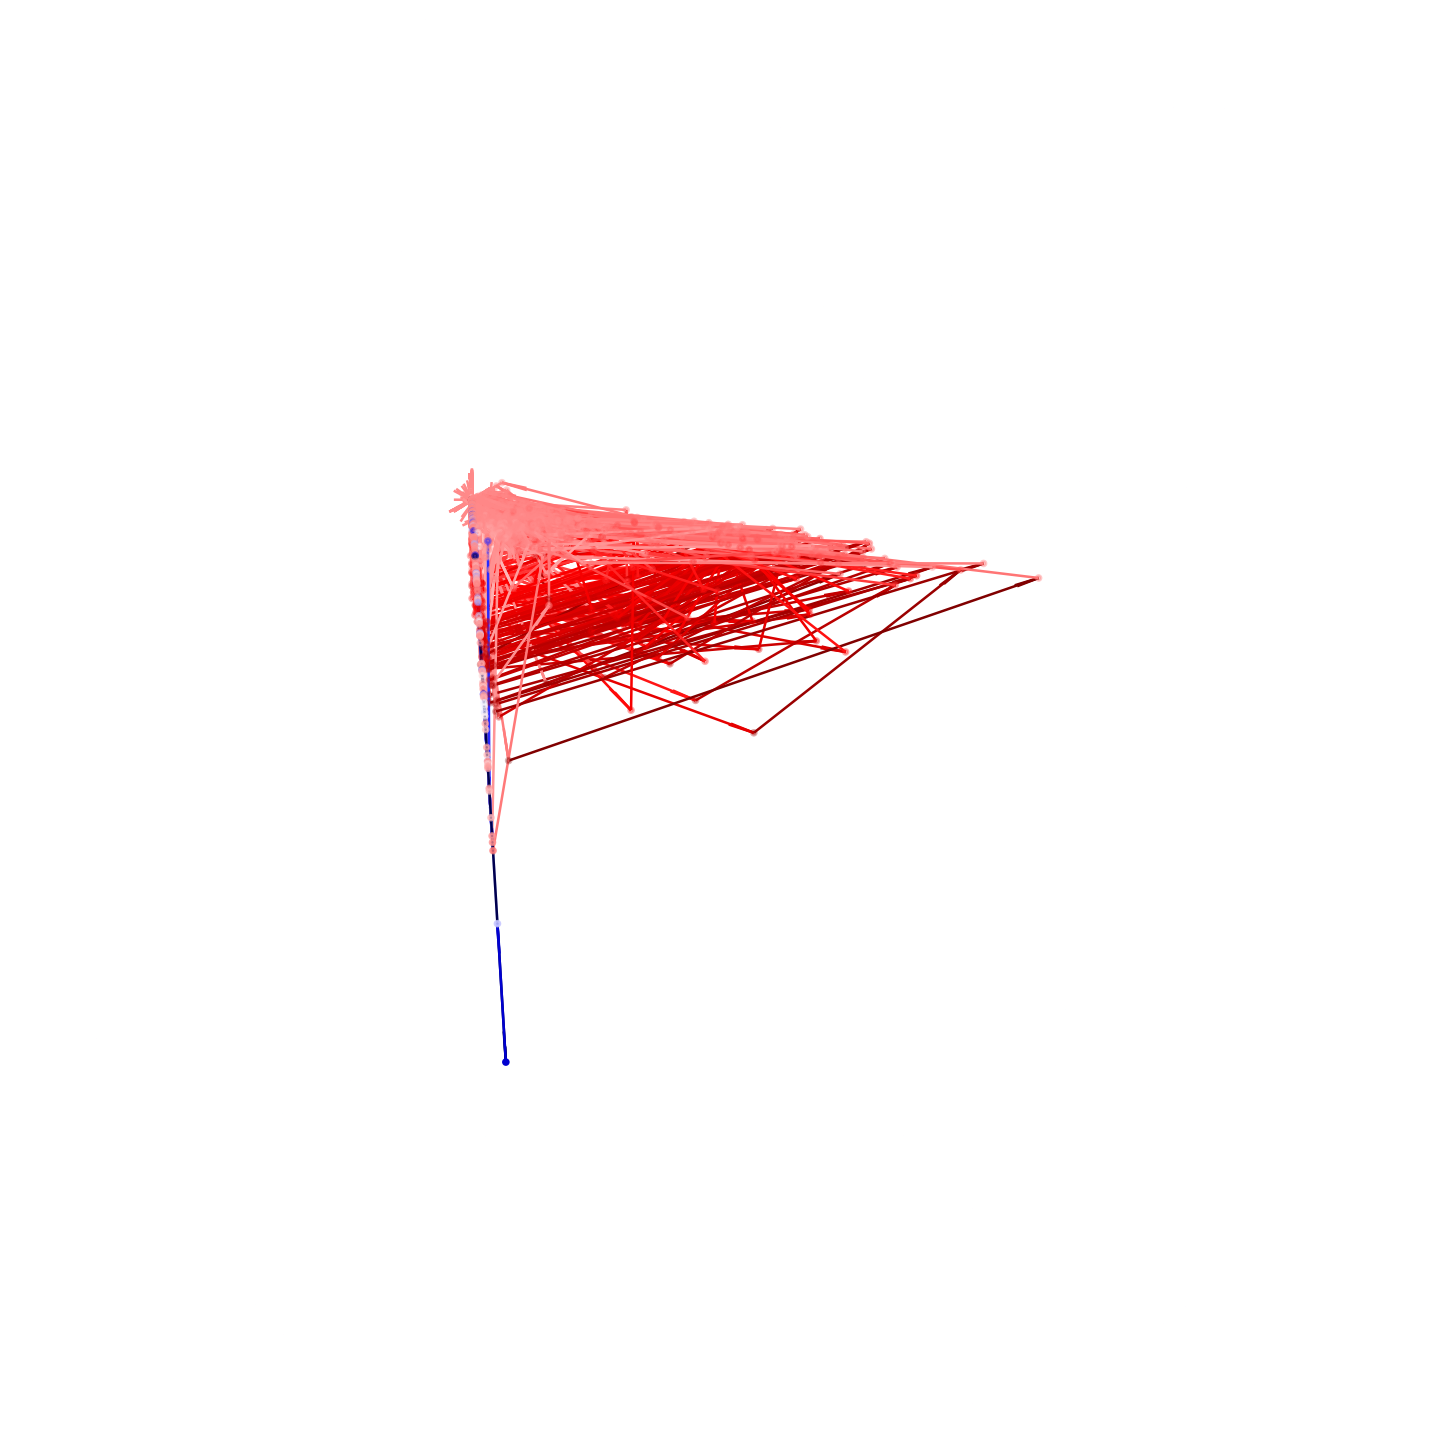

/tmp/ipykernel_102778/3146946992.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)
/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:2606: RuntimeWarning: invalid value encountered in multiply
  arrow_dt = shaft_dt * arrow_length_ratio


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [15]:
plot_phase_space(Y0_, B_[:,0], cmap='seismic', elev=80, azim=-12)

------------------